## This notebook comprises a data analysis of rental listings data, in which we try to estimate rental prices at the city level for SF Bay Area cities. 

### NB: This notebook is essentially a demo of the data_analysis.py script, and to run this script or notebook, we assume we have performed the 1st 2 phases of this webcrawler project: ie, we have already done the following: 1.) Used the webcrawler at least once; & 2.) We have cleaned and wrangled the scraped data, and we have used the Pandas' DataFrame to SQL data pipeline so that we have the data stored into a SQL Server table.

### The steps of this data analysis phase of the project are as follows: 

### A.) We start by importing the data from the SQL rental table, but ensure sqft data are available (ie, WHERE sqft IS NOT NULL) and ensure that price > $1. B.) We then ensure the variables are of the correct data type, and we will remove any columns that are irrelevant to an empirical analysis of rental prices. C.) We then perform some data exploration, such as examining the distribution of several key variables, such as rental price (the outcome variable), number of bedrooms, and square feet. D.) We wrangle, normalize, and prepare the data by using multiple (k-fold) cross validation to split the overall dataset into several segments, each of which will be used to train several different regression models. E.) Finally, we implement The notebook is essentially a demo of the data_analysis.py script:various regression models, including comparing the predictive accuracy of the models. Using the most accurate models, we will make predictions of city-level rental prices.  

In [29]:
# imports:
# file processing
import os
import glob

# data analysis libraries & SQL libraries
import numpy as np
import pandas as pd
# SQL ODBC for API connection between Python & SQL Server
import pyodbc
import sqlalchemy as sa

# data visualization:
import matplotlib as plt
import seaborn as sns

import json

# statistical and ML modeling and hypothesis testing libraries
from sklearn.model_selection import KFold   # k-fold cross validation
from sklearn.model_selection import train_test_split  # split datasets into training & test datasets
from sklearn import linear_model  # OLS 
from sklearn import ensemble  # ensemble module contains the GradientBoostingRegressor class, which is used to estimate Gradient-boosted regression models

from sklearn.metrics import mean_squared_error  # calculate MSE to estimate accuracy of regression models 


## A.) Import data from SQL table, but ensure square feet data is available (ie, is not null) and price > $1: 

In [14]:
# import data from rental table
class SQL_Database():
    def __init__(self, sql_config_path):

        with open(sql_config_path, 'r') as fh:
            config = json.load(fh)

        self.driver = config['driver']
        self.server = config['server']
        self.database = config['database']
        self.username = config['username']
        self.password = config['password']
        print(f"Name of connected database:\n{self.database}")


    def import_SQL_to_df(self, sql_query):
        """Import dataset by using SQL query and Pandas' read_sql() method"""
        conn = pyodbc.connect(
            f'DRIVER={self.driver};'
            f'SERVER={self.server};'
            f'DATABASE={self.database};'
            f'UID={self.username};'
            f'PWD={self.password};'
            'Trusted_Connection=yes;'
        )

        # establish connection to SQL Server database, by passing in the database name, etc., using a with statement so it will automatically close the connection & cursor once the with statement has completed execution:
        # initialize cursor so we can execute SQL code
        cursor = conn.cursor() 

        # query to select all records in which a.) sqft data exists (ie, NOT NULL) and b.) where price > $1, since such a price is essentially impossible and likely a typo from the original scraped rental listing
        # specify SQL query
        sql = sql_query 

        # export SQL query results to Pandas' DataFrame
        df = pd.read_sql(sql,conn)  # export results of SQL query to Pandas' DataFrame

        cursor.close()
        conn.close()
        return df


## import data with no sqft nulls and price >$1, via SQL query to Pandas' df
# specify path to json file containing SQL configuration/username data
sql_config_path = "D:\\Coding and Code projects\\Python\\craigslist_data_proj\\CraigslistWebScraper\\SQL_config\\config.json" 

SQL_db = SQL_Database(sql_config_path)  # NB: be sure to pass in path to the json SQL configuration file so we can load in the needed username, password, and configuration data to be able to access the SQL database

# specify query for data selection
query = """SELECT * FROM rental WHERE sqft is NOT NULL AND price > 1;"""
# import data to DataFrame via SQL query and Pandas' read_sql() method
df = SQL_db.import_SQL_to_df(query)
df.info() # sanity check

Name of connected database:
craigslist
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10904 entries, 0 to 10903
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   listing_id               10904 non-null  int64         
 1   sqft                     10904 non-null  object        
 2   city                     10904 non-null  object        
 3   price                    10904 non-null  int64         
 4   bedrooms                 10904 non-null  int64         
 5   bathrooms                10904 non-null  object        
 6   attr_vars                10904 non-null  object        
 7   date_of_webcrawler       10904 non-null  datetime64[ns]
 8   kitchen                  10904 non-null  int64         
 9   date_posted              10904 non-null  datetime64[ns]
 10  region                   10904 non-null  object        
 11  sub_region               10904 non-null  object       

## B.) Ensure each column is of the correct data type, and remove columns that are irrelevant to quantifying rental price:

### B1.)a) NB: A priori, we know that sqft will be parsed as a Pandas' object data type since the SQL table stores this column as a varchar data type. 

### B1.)b) As a result, we will *at least* need to transform the data type for sqft, and possibly other columns as well: 

In [16]:
## Data cleaning and feature engineering--ensure columns are of correct data type:
print(f"Data types of each column from queried SQL rental table:\n{df.dtypes}")

Data types of each column from queried SQL rental table:
listing_id                          int64
sqft                               object
city                               object
price                               int64
bedrooms                            int64
bathrooms                          object
attr_vars                          object
date_of_webcrawler         datetime64[ns]
kitchen                             int64
date_posted                datetime64[ns]
region                             object
sub_region                         object
cats_OK                             int64
dogs_OK                             int64
wheelchair_accessible               int64
laundry_in_bldg                     int64
no_laundry                          int64
washer_and_dryer                    int64
washer_and_dryer_hookup             int64
laundry_on_site                     int64
full_kitchen                        int64
dishwasher                          int64
refrigerator       

In [18]:
df.sqft.value_counts()

700.0     283
850.0     271
950.0     226
600.0     225
750.0     216
         ... 
338.0       1
2348.0      1
2106.0      1
468.0       1
776.0       1
Name: sqft, Length: 1013, dtype: int64

In [20]:
df.bedrooms.value_counts()

2    4435
1    4232
3    1056
0     904
4     220
5      44
6       8
8       4
7       1
Name: bedrooms, dtype: int64

In [21]:
df.bathrooms.value_counts()

1.0    6894
2.0    3057
1.5     472
2.5     297
3.0     130
3.5      28
4.0      14
9.0       8
5.0       2
5.5       2
Name: bathrooms, dtype: int64

### Notice that sqft is being parsed as object (as expected), so let's change data type for sqft:

In [ ]:
# change sqft data type to int
def to_int(df, col):
    pass

df['sqft'] = to_int(df, 'sqft')

## C.) Data exploration and visualizations


### Let's start by examining the distributions of several key variables such as rental price, # of bedrooms, # of bathrooms, and sqft:





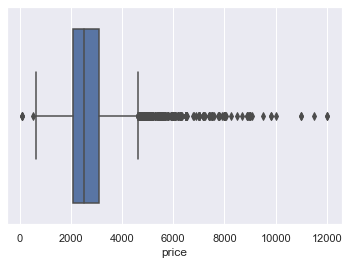

In [41]:
## boxplots of important variables
def boxplot(df, col, hue_option_col):
    """Implement boxplot of given col from given dataset (df)"""
    sns.set_theme(style="darkgrid")
    ax = sns.boxplot(x=df[col], hue=hue_option_col)
    

## distribution of price (overall dataset) boxplot
boxplot(df, 'price', None) # distribution of price overall


### At first glance, notice that the distribution of price is highly positively skewed, with the upper quartile of rental prices having values that exceed the median value of price (roughly $2,500) very substantially.

### Next, let's examine the data at a somewhat finer granmularity: examine a boxplot of price, but differentiate the price distributions by the number of bedrooms:

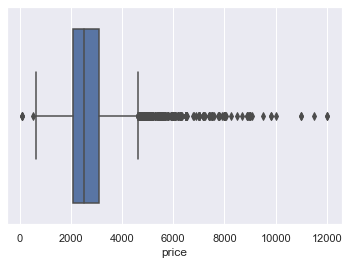

In [42]:

## distribution of price by number of bedrooms boxplot
boxplot(df, 'price', df['bedrooms']) # distribution of price by number of bedrooms

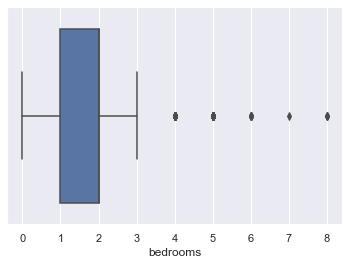

In [43]:
## distribution of number of bedrooms boxplot
boxplot(df, 'bedrooms', None) # distribution of  number of bedrooms

In [44]:
## distribution of number of bathrooms boxplot
boxplot(df, 'bathrooms', None) # distribution of  number of bathrooms

TypeError: Horizontal orientation requires numeric `x` variable.

### Examine distribution of data by whether a rental is furnished:

In [25]:
# distribution of data by is furnished: 
df.is_furnished.value_counts()

0    10271
1      633
Name: is_furnished, dtype: int64

### Data visualizations and data exploration-- Countplots of variables such as # of bedrooms, and include percent of total:


### Among the relatively few rental listings that are furnished, how many bedrooms do these rental listings tend to have relative to non-furnished rental listings?:

### Countplot of # of bedrooms by whether the rental is furnished:

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 44

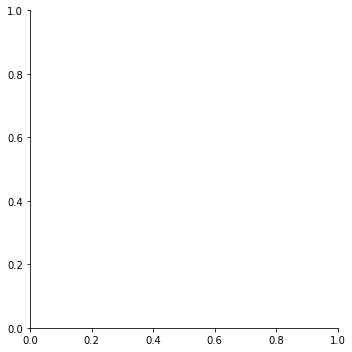

In [31]:
# countplot of number of bedrooms by whether a rental is furnished:




# group dataset by is_furnished, and look up the % of total distributions of the number of bedrooms:
df_bedrooms = df.groupby('bedrooms')['is_furnished'].value_counts(normalize=True)
df_bedrooms = df_bedrooms.mul(100)
df_bedrooms = df_bedrooms.rename('percent').reset_index()

g = sns.catplot(x=df['bedrooms'],y='percent',hue=df['is_furnished'],kind='bar',data=df_bedrooms)
g.ax.set_ylim(0,100)

for perc in g.ax.patches:
    txt = str(perc.get_height().round(1)) + '%'
    txt_x = perc.get_x() 
    txt_y = perc.get_height()
    g.ax.text(txt_x,txt_y,txt)

### How does the number of bedrooms relate to the number of bathrooms?

### Countplot of the distribution of the number of bedrooms by the number of bathrooms:

In [ ]:
# countplot of number of bedrooms- distribution by # of bathrooms


### Next, let's examine correlations of variables with rental price (ie, the outcome variable)

In [ ]:
# scatterplot of sqft and rental price

In [ ]:
# scatterplot of # of bedrooms and rental price

## Next, let's examine the data at the subregion level (ie, sfc vs sby, etc.) and then at the city level

In [ ]:
### group data by subregion level




In [ ]:
## visualize and compare avg prices by subregion

In [ ]:
## group data by city level



In [ ]:
## visualize and compare avg prices by city

In [ ]:
### group data by housing type--ie, apt (apartment), single_fam (ie, single family), townhouse, etc.



In [ ]:
## D.) Prepare the data for regression analysis-- bifurcate the DataFrame into the outcome variable and the covariates (ie, RHS variables), respectively

# bifurcate dataset


# 

In [ ]:
# D) - cont'd: normalize the datasetys

In [ ]:
# D) - cont'd:   use k-fold cross validation



## E.) Perform regression analysis, interpret models, determine accuracy of models, and make predictions: